In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from tqdm import tqdm
import glob
import os
import json
import pickle
from einops import rearrange
from captum.attr import DeepLift, Saliency
from captum.attr import visualization as viz

C:\Users\saeed\Desktop\Master\bci\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('bilab_10mfc_train.pkl', 'rb') as f:
    mfc_train = pickle.load(f)
with open('bilab_10mfc_test.pkl', 'rb') as f:
    mfc_test = pickle.load(f)
with open("data/bilabial/y_bilabial_train.pkl", "rb") as f:
    y__train = pickle.load(f)
with open("data/bilabial/y_bilabial_test.pkl", "rb") as f:
    y__test = pickle.load(f)

In [3]:
trials = []
for trial in mfc_train:
    pic = np.zeros((7,9,10,11))
    pic[0,2] = trial[3]
    pic[0,3] = trial[0]
    pic[0,4] = trial[1]
    pic[0,5] = trial[2]
    pic[0,6] = trial[4]
    pic[1,:] = trial[5:14]
    pic[2,:] = trial[14:23]
    pic[3,:] = trial[23:32]
    pic[4,:] = trial[32:41]
    pic[5,:] = trial[41:50]
    pic[6,0] = trial[50]
    pic[6,1] = trial[51]
    pic[6,2] = trial[52]
    pic[6,3] = trial[58]
    pic[6,4] = trial[53]
    pic[6,5] = trial[60]
    pic[6,6] = trial[54]
    pic[6,7] = trial[55]
    pic[6,8] = trial[56]
    trials.append(pic)
picture_data_train = np.array(trials)
trials = []
for trial in mfc_test:
    pic = np.zeros((7,9,10,11))
    pic[0,2] = trial[3]
    pic[0,3] = trial[0]
    pic[0,4] = trial[1]
    pic[0,5] = trial[2]
    pic[0,6] = trial[4]
    pic[1,:] = trial[5:14]
    pic[2,:] = trial[14:23]
    pic[3,:] = trial[23:32]
    pic[4,:] = trial[32:41]
    pic[5,:] = trial[41:50]
    pic[6,0] = trial[50]
    pic[6,1] = trial[51]
    pic[6,2] = trial[52]
    pic[6,3] = trial[58]
    pic[6,4] = trial[53]
    pic[6,5] = trial[60]
    pic[6,6] = trial[54]
    pic[6,7] = trial[55]
    pic[6,8] = trial[56]
    trials.append(pic)  
picture_data_test = np.array(trials)

In [5]:
dataset = np.vstack((picture_data_train, picture_data_test))
dataset.shape

(1913, 7, 9, 10, 11)

In [32]:
labels = y__train + y__test

In [2]:
#model

class CNN_RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(20, 16, 3)
        #torch.nn.init.xavier_normal_(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 1)
        self.conv2 = nn.Conv2d(16, 32, 3)
        #torch.nn.init.xavier_normal_(self.conv2.weight)
        self.lstm = nn.LSTM(input_size=256, hidden_size=128, num_layers=2, batch_first=True)
        self.fc = nn.Linear(128, 2)
        #torch.nn.init.xavier_normal_(self.fc.weight)
        self.batch1 = nn.BatchNorm2d(16)
        self.batch2 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
    
    
    def forward(self, x):
        hidden = torch.zeros(2, x.shape[0], 128), torch.zeros(2, x.shape[0], 128)
        # (batch, heigth, width, feature, time)
        #print(x.shape)
        x = rearrange(x, 'batch heigth width feature time -> (batch time) feature heigth width')
        #print(x.shape)
        out = self.pool(self.relu1(self.batch1(self.conv1(x))))
        #print(out.shape)
        out = self.relu2(self.batch2(self.conv2(out)))
        #print(out.shape)
        out = rearrange(out, '(batch time) channel heigth width -> batch time (channel heigth width)', time=11)
        #print(out.shape)
        out, hidden = self.lstm(out, hidden) 
        out = out[:,-1,:]
        out = self.fc(out)
        return out
    
class FC(nn.Module):
    def __init__(self, hidden1=500):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(6820, hidden1)
        torch.nn.init.xavier_normal(self.fc1.weight)
        self.fc2 = nn.Linear(hidden1, 1)
        torch.nn.init.xavier_normal(self.fc2.weight)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = x.view(-1, 6820)
        x = F.relu(self.fc1(x))
        #x = self.dropout(x)
        x = F.sigmoid(self.fc2(x))
        return x
    
class cnn3d(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv3d(20, 16, kernel_size=(3, 3, 3), padding=1)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=0)
        self.pool = nn.MaxPool3d((2, 2, 2), stride=2)
        self.fc1 = nn.Linear(192, 128)
        self.fc2 = nn.Linear(128, 1)
        self.drop = nn.Dropout(0.25)
        self.batch1 = nn.BatchNorm3d(16)
        self.batch2 = nn.BatchNorm3d(32)
        self.batch3 = nn.BatchNorm1d(128)
        
    def forward(self, x):
        x = rearrange(x, 'n h w m t -> n m t h w')
        out = self.pool(F.relu(self.batch1(self.conv1(x))))
        out = F.relu(self.batch2(self.conv2(out)))
        out = out.view(out.size(0), -1)
        out = self.drop(F.relu(self.batch3(self.fc1(out))))
        out = F.sigmoid(self.fc2(out))
        return out

In [85]:
with open("data/normal_all_data.pkl", "rb") as f:
    all_data = pickle.load(f)
with open("data/11_20mfc.pkl", "rb") as f:
    data = pickle.load(f)
with open("data/all_label.pkl", "rb") as f:
    labels = pickle.load(f)
with open("data/vowel_label.pkl", "rb") as f:
    vowel_label = pickle.load(f)
with open("data/bilab_label.pkl", "rb") as f:
    bilab_label = pickle.load(f)
with open("data/nasal_label.pkl", "rb") as f:
    nasal_label = pickle.load(f)
with open("data/iy_label.pkl", "rb") as f:
    iy_label = pickle.load(f)
with open("data/uw_label.pkl", "rb") as f:
    uw_label = pickle.load(f)

print(all_data.shape, len(uw_label))

(1913, 62, 20, 11) 1913


In [86]:
trials = []
for trial in all_data:
    pic = np.zeros((7,9,20,11))
    pic[0,2] = trial[3]
    pic[0,3] = trial[0]
    pic[0,4] = trial[1]
    pic[0,5] = trial[2]
    pic[0,6] = trial[4]
    pic[1,:] = trial[5:14]
    pic[2,:] = trial[14:23]
    pic[3,:] = trial[23:32]
    pic[4,:] = trial[32:41]
    pic[5,:] = trial[41:50]
    pic[6,0] = trial[50]
    pic[6,1] = trial[51]
    pic[6,2] = trial[52]
    pic[6,3] = trial[58]
    pic[6,4] = trial[53]
    pic[6,5] = trial[60]
    pic[6,6] = trial[54]
    pic[6,7] = trial[55]
    pic[6,8] = trial[56]
    trials.append(pic)
picture_data_train = np.array(trials)

In [87]:
dataset = picture_data_train
labels = nasal_label
print(dataset.shape, len(labels))

(1913, 7, 9, 20, 11) 1913


In [253]:
Max = np.max(dataset, axis=(0,1,2,4), keepdims=True)
Min = np.min(dataset, axis=(0,1,2,4), keepdims=True)
dataset = (dataset-Min)/(Max-Min)
dataset.shape

(1913, 7, 9, 20, 11)

In [256]:
model = CNN_RNN().float()
model.load_state_dict(torch.load('train/model0_acc.pt'))

<All keys matched successfully>

In [85]:
label = []
for l in labels:
    label.append(l)

In [257]:
sample = torch.from_numpy(dataset)
#data = torch.rand((7,9,20,11))
sample = sample.float()
sample.requires_grad = True
print(sample.shape)

torch.Size([1913, 7, 9, 20, 11])


In [258]:
model.eval()

CNN_RNN(
  (conv1): Conv2d(20, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=2, bias=True)
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (relu2): ReLU()
)

In [259]:
def attribute_image_features(algorithm, data, **kwargs):
    model.zero_grad()
    tensor_attributions = algorithm.attribute(data,
                                              target=labels,
                                              **kwargs
                                             )
    
    return tensor_attributions

In [260]:
dl = DeepLift(model)
#attr_dl = dl.attribute(data, labels)
attr_dl = attribute_image_features(dl, sample, baselines=sample * 0)

print(attr_dl.shape)

torch.Size([1913, 7, 9, 20, 11])


In [261]:
attr_dl = attr_dl.detach().numpy()

In [262]:
with open('sal_nasal.pkl', 'wb') as f:
    pickle.dump(attr_dl, f)

In [217]:
with open('sal_vowel.pkl', 'rb') as f:
    attr_dl = pickle.load(f)

In [218]:
attr_dl.shape

(1913, 7, 9, 20, 11)

(1913, 7, 9, 20, 11)
(7, 9, 20)
(20, 63)
(array([ 2,  3,  9,  2, 16], dtype=int64), array([21, 32, 32, 22, 20], dtype=int64))


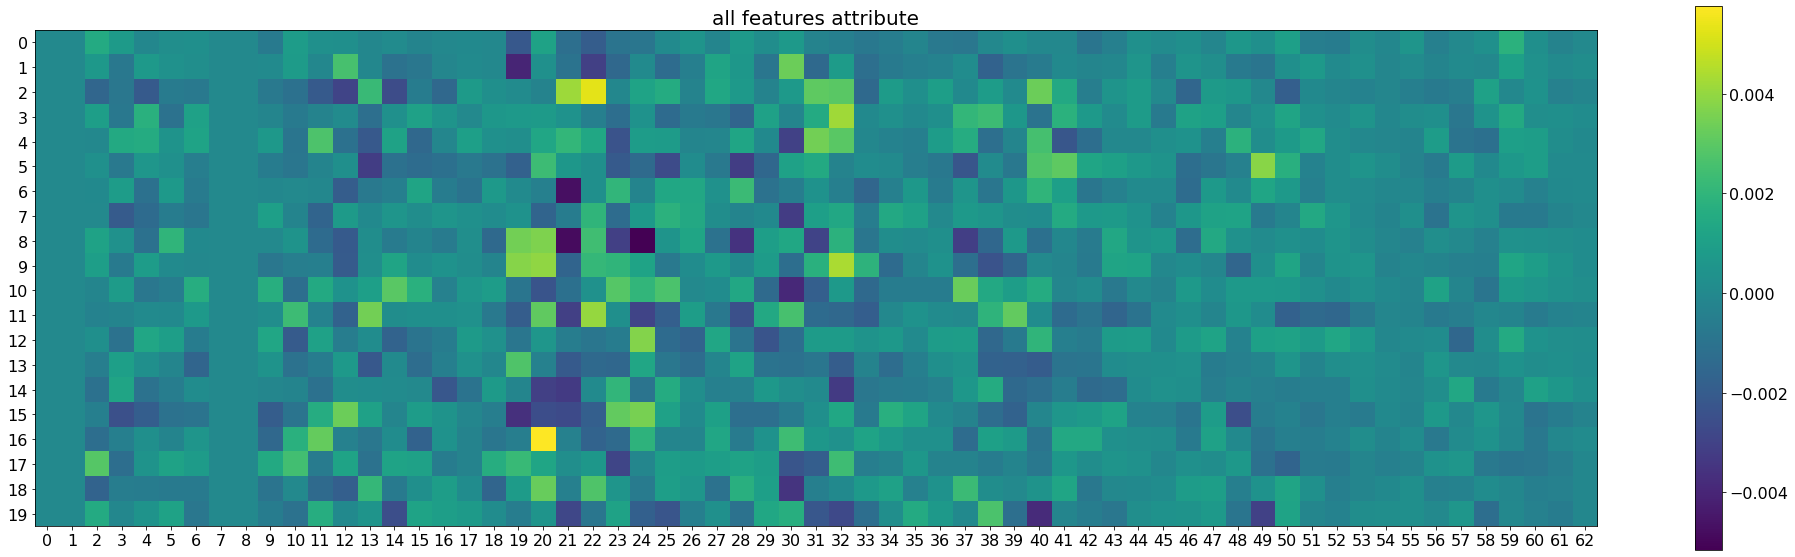

"for i in range(attr.shape[-1]):\n    final = attr[:,:,i]\n    plt.imshow(final, cmap='viridis', interpolation='nearest')\n    plt.colorbar()\n    plt.title('MFC'+str(i+1))\n    plt.show()"

In [219]:
#origin = datashape[0,:,:,0,0]
print(attr_dl.shape)
attr = np.mean(attr_dl, axis=(0, 4))
print(attr.shape)
'''with open('vowel_electrode.pkl', 'wb') as f:
    pickle.dump(attr, f)'''

'''_ = viz.visualize_image_attr(final, original, method="blended_heat_map",sign="all",show_colorbar=True, 
                      title="Overlayed DeepLift")'''
'''plt.figure(figsize=(8, 8))
plt.imshow(attr, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.title('electrode attribute')
plt.show()'''
#plt.savefig('electode_uw.png', dpi=300)

'''plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_facecolor((0.95,0.95,0.95))
plt.grid()
plt.bar(x=range(20), height=attr, tick_label=range(20))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('MFCC attribute')
plt.show()'''
All=[]
for i in range(20):
    All.append(attr[:,:,i])
All = np.stack(All)
All = All.reshape((20,63))
print(All.shape)
print(np.unravel_index(np.argsort(All, axis=None)[-5:], All.shape))
plt.figure(figsize=(35, 10))
ax = plt.gca()
ax.set_xticks(range(63))
ax.set_yticks(range(20))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.imshow(All, cmap='viridis', interpolation='nearest')
plt.title('all features attribute', fontsize=20)
cbar = plt.colorbar()
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(16)
plt.show()
'''for i in range(attr.shape[-1]):
    final = attr[:,:,i]
    plt.imshow(final, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title('MFC'+str(i+1))
    plt.show()'''

In [83]:
print(sum(y__test)/(len(y__test)))

0.3645833333333333


In [271]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(20, 16, 3)
        #torch.nn.init.xavier_normal_(self.conv1.weight)
        self.pool = nn.MaxPool2d(2, 1)
        self.conv2 = nn.Conv2d(16, 32, 3)
        #torch.nn.init.xavier_normal_(self.conv2.weight)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 1)
        #torch.nn.init.xavier_normal_(self.fc.weight)
        self.batch1 = nn.BatchNorm2d(16)
        self.batch2 = nn.BatchNorm2d(32)
    
    def forward(self, x):
        # (batch, heigth, width, feature)
        #print(x.shape)
        x = rearrange(x, 'batch heigth width feature -> batch feature heigth width')
        #print(x.shape)
        out = self.pool(F.relu(self.batch1(self.conv1(x))))
        #print(out.shape)
        out = F.relu(self.batch2(self.conv2(out)))
        #print(out.shape)
        out = rearrange(out, 'batch channel heigth width -> batch (channel heigth width)')
        #print(out.shape)
        out = F.relu(self.fc1(out))
        out = F.sigmoid(self.fc2(out))
        return out

In [15]:
with open('sal_nasal.pkl', 'rb') as f:
    dataset = pickle.load(f)
dataset.shape

(1913, 7, 9, 20, 11)

In [16]:
data = np.mean(dataset, axis=4)
labels = nasal_label
print(data.shape, len(labels))

(1913, 7, 9, 20) 1913


In [283]:
data1 = []
for sample in data:
    data1.append(sample)
len(data1)

1913

In [284]:
#config
val_size = 0.15
n_epochs = 100
batch_size = 128
print_every = 10
k = 10
skf=StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

In [285]:
train_accs, test_accs = [], []
train_accs_over, test_accs_over = [], []
train_accs_acc, test_accs_acc = [], []

for fold, (train_val_idx, test_idx) in enumerate(skf.split(data1, labels)):
    
    print('-----------------------------Fold {}---------------'.format(fold + 1))

    
    print('preparing dataloaders...')
    print(data.shape)
    train_val_data = np.stack([data1[index] for index in train_val_idx])
    train_val_label = [labels[index] for index in train_val_idx]
    test_data = np.stack([data1[index] for index in test_idx])
    test_label = [labels[index] for index in test_idx]
    
    
    Max = np.max(train_val_data, axis=(0,1,2), keepdims=True)
    Min = np.min(train_val_data, axis=(0,1,2), keepdims=True)
    train_val_data = (train_val_data-Min)/(Max-Min)
    
    Max_test = np.max(test_data, axis=(0,1,2), keepdims=True)
    Min_test = np.min(test_data, axis=(0,1,2), keepdims=True)
    test_data = (test_data-Min)/(Max-Min)
    
    
    train_val = [[train_val_data[i], train_val_label[i]] for i in range(len(train_val_data))]
    test = [[test_data[i], test_label[i]] for i in range(len(test_data))]
    
    num_train_val = len(train_val)
    indices = list(range(num_train_val))
    np.random.shuffle(indices)
    split = int(np.floor(val_size*num_train_val))
    train, val = [train_val[i] for i in indices[split:]] ,[train_val[i] for i in indices[:split]]
    
    train_labels = [data[1] for data in train]
    
    oversample = 1
    _, counts = np.unique(train_labels, return_counts=True)
    if oversample==1:
        if counts[1]>counts[0]:
            label0 = [data for data in train if data[1]==0]
            coef = int(counts[1]/counts[0])
            print('coef when 1 > 0', coef)
            for i in range(coef):
                train = train + label0
        elif counts[1]<counts[0]:
            label1 = [data for data in train if data[1]==1]
            coef = int(counts[0]/counts[1])
            print('coef when 0 > 1', coef)
            for i in range(coef):
                train = train + label1
    

    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)
    
    print('creating model...')
    model = cnn().float()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    criterion = nn.BCELoss()
    
    print('calculating total steps...')
    steps = 0
    for epoch in range(n_epochs):
        for data, label in train_loader:
            steps += 1

    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=steps, max_lr=0.001)
    scheduler1 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
    l1_lambda = 0.0001
    
    min_val_loss = np.inf
    max_val_acc = 0
    
    for epoch in range(n_epochs):
        print('epoch: ', epoch+1)
        train_loss = 0
        l1_loss = 0
        train_correct = 0
        model.train()
        '''for name, param in model.named_parameters():
                print(name, param.data)
                break'''
        for iteration, (data,label) in enumerate(train_loader):
            #print('\ndata = ', torch.amax(data, axis=(0,1,2,4)), torch.amin(data, axis=(0,1,2,4)))
            optimizer.zero_grad()
            output = model(data.float())
            label = torch.reshape(label, (-1,1))
            label = label.float()
            loss = criterion(output, label)
            add_loss = loss
            ex_loss = 0
            for W in model.parameters():
                ex_loss += l1_lambda*W.norm(1)
                loss = loss + l1_lambda*W.norm(1)    
            loss.backward()
            optimizer.step()
            scheduler.step()
            targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
            train_correct += sum(targets)
            train_loss += add_loss.item()*data.shape[0]
            l1_loss += ex_loss.item()*data.shape[0]
            
            if iteration % print_every == 0:
                is_training = True
                val_loss = 0
                val_correct = 0
                model.eval()
                for data, label in val_loader:
                    output = model(data.float())
                    label = torch.reshape(label, (-1,1))
                    label = label.float()
                    loss = criterion(output, label) 
                    val_loss += loss.item()*data.shape[0]
                    targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
                    val_correct += sum(targets)
                val_loss = val_loss/len(val_loader.sampler)
                val_acc = val_correct/len(val_loader.sampler)

                if val_loss <= min_val_loss:
                    print("validation loss decreased ({:.6f} ---> {:.6f}),   val_acc = {}".format(min_val_loss, val_loss, val_acc))
                    torch.save(model.state_dict(), 'sal/model'+str(fold)+'.pt')
                    min_val_loss = val_loss
                if val_acc >= max_val_acc:
                    print("validation acc increased ({:.6f} ---> {:.6f})".format(max_val_acc, val_acc))
                    torch.save(model.state_dict(), 'sal/model'+str(fold)+'_acc.pt')
                    max_val_acc = val_acc
                torch.save(model.state_dict(), 'sal/last_model'+str(fold)+'.pt')
                model.train(mode=is_training)
                
        train_acc = train_correct/len(train_loader.sampler)       
        train_loss = train_loss/len(train_loader.sampler)
        loss1 = l1_loss/len(train_loader.sampler)
        
        val_loss = 0
        val_correct = 0
        model.eval()
        for data, label in val_loader:
            output = model(data.float())
            label = torch.reshape(label, (-1,1))
            label = label.float()
            loss = criterion(output, label) 
            val_loss += loss.item()*data.shape[0]
            targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
            val_correct += sum(targets)
            
        val_loss = val_loss/len(val_loader.sampler)
        val_acc = val_correct/len(val_loader.sampler)
        
        print('epoch {}: train loss = {},   l1loss = {},   train acc = {},\nval_loss = {},     val_acc = {}\n'
              .format(epoch+1, train_loss, loss1, train_acc, val_loss, val_acc))
        if int(train_acc)==1:
            print('!!! overfitted !!!')
            break
        model.train()
        #scheduler1.step(val_loss)
            
    model =cnn().float()
    model.load_state_dict(torch.load('sal/model'+str(fold)+'.pt'))
    
    n_correct = 0
    model.eval()
    for data, label in test_loader:
        output = model(data.float())
        targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
        print(targets)
        n_correct += sum(targets)
        
    test_accs.append(n_correct/len(test_loader.sampler))
    print('early stoping results:\n\t', test_accs)
    
    n_correct = 0
    model.eval()
    for data, label in train_loader:
        output = model(data.float())
        print('output = ', [output[i].round().item() for i in range(len(label))])
        print('label = ', label)
        targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
        n_correct += sum(targets)
        
    train_accs.append(n_correct/len(train_loader.sampler))
    print('\t', train_accs)
    
    model = cnn().float()
    model.load_state_dict(torch.load('sal/last_model'+str(fold)+'.pt'))
    
    n_correct = 0
    model.eval()
    for data, label in test_loader:
        output = model(data.float())
        targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
        print(targets)
        n_correct += sum(targets)
    test_accs_over.append(n_correct/len(test_loader.sampler))
    print('full train results:\n\t', test_accs_over)
    
    n_correct = 0
    model.eval()
    for data, label in train_loader:
        output = model(data.float())
        targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
        n_correct += sum(targets)
    train_accs_over.append(n_correct/len(train_loader.sampler))
    print('\t', train_accs_over)
    
    model = cnn().float()
    model.load_state_dict(torch.load('sal/model'+str(fold)+'_acc.pt'))
    
    n_correct = 0
    model.eval()
    for data, label in test_loader:
        output = model(data.float())
        targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
        print(targets)
        n_correct += sum(targets)
    test_accs_acc.append(n_correct/len(test_loader.sampler))
    print('best accs results:\n\t', test_accs_acc)
    
    n_correct = 0
    model.eval()
    for data, label in train_loader:
        output = model(data.float())
        targets = [1 if output[i].round()==label[i] else 0 for i in range(len(label))]
        n_correct += sum(targets)
    train_accs_acc.append(n_correct/len(train_loader.sampler))
    print('\t', train_accs_acc)
    print(test_label)

-----------------------------Fold 1---------------
preparing dataloaders...
(1913, 7, 9, 20)
coef when 0 > 1 1
creating model...
calculating total steps...
epoch:  1
validation loss decreased (inf ---> 0.698440),   val_acc = 0.3953488372093023
validation acc increased (0.000000 ---> 0.395349)


C:\Users\saeed\Desktop\Master\bci\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


validation acc increased (0.395349 ---> 0.395349)
epoch 1: train loss = 0.6869507828848291,   l1loss = 0.13827660727062954,   train acc = 0.5616507297433316,
val_loss = 0.71086893987286,     val_acc = 0.3953488372093023

epoch:  2
validation acc increased (0.395349 ---> 0.395349)
validation acc increased (0.395349 ---> 0.395349)
epoch 2: train loss = 0.6654115830706062,   l1loss = 0.13782025073482934,   train acc = 0.6205334675390035,
val_loss = 0.7223108600276386,     val_acc = 0.3953488372093023

epoch:  3
validation acc increased (0.395349 ---> 0.395349)
validation acc increased (0.395349 ---> 0.430233)
epoch 3: train loss = 0.6485615584738721,   l1loss = 0.13727900934057374,   train acc = 0.6396577755410167,
val_loss = 0.7128145556117214,     val_acc = 0.5

epoch:  4
validation acc increased (0.430233 ---> 0.503876)
validation loss decreased (0.698440 ---> 0.692173),   val_acc = 0.5310077519379846
validation acc increased (0.503876 ---> 0.531008)
epoch 4: train loss = 0.63309154347

epoch 38: train loss = 0.07791504205383123,   l1loss = 0.09236309195530733,   train acc = 0.9793658782083543,
val_loss = 3.233410909194355,     val_acc = 0.5736434108527132

epoch:  39
epoch 39: train loss = 0.06921992062487432,   l1loss = 0.09197287779689495,   train acc = 0.9854051333668847,
val_loss = 3.561995010505351,     val_acc = 0.5852713178294574

epoch:  40
epoch 40: train loss = 0.09455262519377947,   l1loss = 0.09194954407083131,   train acc = 0.9703069954705587,
val_loss = 3.140381110104725,     val_acc = 0.562015503875969

epoch:  41
epoch 41: train loss = 0.04864857653104365,   l1loss = 0.09150668548229776,   train acc = 0.9899345747357826,
val_loss = 3.4616599368552365,     val_acc = 0.5426356589147286

epoch:  42
epoch 42: train loss = 0.03882463321757185,   l1loss = 0.09062009955703403,   train acc = 0.9924509310518369,
val_loss = 3.4793882855149203,     val_acc = 0.5891472868217055

epoch:  43
epoch 43: train loss = 0.028278966656936192,   l1loss = 0.0895980896665393

output =  [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label =  tensor([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
        1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
        1, 1, 1, 0, 

	 [0.9949672873678913]
[1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]
best accs results:
	 [0.59375]
	 [0.8037242073477604]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,

epoch 29: train loss = 0.21259009558988842,   l1loss = 0.09493379782573934,   train acc = 0.9154078549848943,
val_loss = 1.3550787757533465,     val_acc = 0.5930232558139535

epoch:  30
epoch 30: train loss = 0.17986376305961416,   l1loss = 0.0943629225155138,   train acc = 0.93202416918429,
val_loss = 3.399730042824269,     val_acc = 0.5813953488372093

epoch:  31
epoch 31: train loss = 0.1377756273278297,   l1loss = 0.09381341631829078,   train acc = 0.9587109768378651,
val_loss = 1.4636259065117947,     val_acc = 0.5930232558139535

epoch:  32
epoch 32: train loss = 0.15627087596409991,   l1loss = 0.09361198741083539,   train acc = 0.9370594159113796,
val_loss = 2.010465736427144,     val_acc = 0.5930232558139535

epoch:  33
epoch 33: train loss = 0.21454838335454043,   l1loss = 0.09376692507052109,   train acc = 0.904833836858006,
val_loss = 3.555855639821258,     val_acc = 0.5813953488372093

epoch:  34
epoch 34: train loss = 0.1433841212908667,   l1loss = 0.09360743821237502,   t

output =  [0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
label =  tensor([0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 

epoch 13: train loss = 0.520279674302964,   l1loss = 0.11765421265572833,   train acc = 0.7127819548872181,
val_loss = 0.8685980189678281,     val_acc = 0.49224806201550386

epoch:  14
validation acc increased (0.500000 ---> 0.500000)
epoch 14: train loss = 0.5055005631948772,   l1loss = 0.11437528439631738,   train acc = 0.7298245614035088,
val_loss = 1.0051480910574744,     val_acc = 0.5

epoch:  15
validation acc increased (0.500000 ---> 0.500000)
validation acc increased (0.500000 ---> 0.500000)
epoch 15: train loss = 0.48474925627983306,   l1loss = 0.11120888095601161,   train acc = 0.7518796992481203,
val_loss = 0.7568337228871131,     val_acc = 0.5155038759689923

epoch:  16
validation acc increased (0.500000 ---> 0.500000)
validation acc increased (0.500000 ---> 0.635659)
epoch 16: train loss = 0.47231552145236116,   l1loss = 0.10832016670091409,   train acc = 0.7543859649122807,
val_loss = 0.8228741385215936,     val_acc = 0.5

epoch:  17
epoch 17: train loss = 0.4447837758333

[1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0]
[1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0]
full train results:
	 [0.59375, 0.5885416666666666, 0.6354166666666666]
	 [0.9949672873678913, 0.9974823766364552, 0.8666666666666667]
[0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0

epoch 28: train loss = 0.19921719834595145,   l1loss = 0.09572086222990306,   train acc = 0.9171656686626747,
val_loss = 1.3161783601886543,     val_acc = 0.5697674418604651

epoch:  29
epoch 29: train loss = 0.17246595051831115,   l1loss = 0.09554041276672881,   train acc = 0.937624750499002,
val_loss = 3.398609378820582,     val_acc = 0.6589147286821705

epoch:  30
epoch 30: train loss = 0.19262273220007053,   l1loss = 0.09535936463973717,   train acc = 0.9166666666666666,
val_loss = 3.561779273572818,     val_acc = 0.6550387596899225

epoch:  31
epoch 31: train loss = 0.13978799877171508,   l1loss = 0.09458633950965371,   train acc = 0.9545908183632734,
val_loss = 3.981414251124248,     val_acc = 0.6511627906976745

epoch:  32
epoch 32: train loss = 0.13305879046698055,   l1loss = 0.09435142839918594,   train acc = 0.9491017964071856,
val_loss = 1.737026299617087,     val_acc = 0.5852713178294574

epoch:  33
epoch 33: train loss = 0.15574632034806196,   l1loss = 0.09403544885967068,

[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1]
[1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0]
full train results:
	 [0.59375, 0.5885416666666666, 0.6354166666666666, 0.612565445026178]
	 [0.9949672873678913, 0.9974823766364552, 0.8666666666666667, 0.8393213572854291]
[1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0

epoch 22: train loss = 0.35131114540723307,   l1loss = 0.10210657698411493,   train acc = 0.8307461191787682,
val_loss = 1.7831758935322133,     val_acc = 0.6356589147286822

epoch:  23
epoch 23: train loss = 0.3259180520974103,   l1loss = 0.10085294403146969,   train acc = 0.8487731597396094,
val_loss = 1.6435921807275262,     val_acc = 0.5155038759689923

epoch:  24
epoch 24: train loss = 0.2837501486421049,   l1loss = 0.09979496815306697,   train acc = 0.871807711567351,
val_loss = 2.8983472193683344,     val_acc = 0.6395348837209303

epoch:  25
validation acc increased (0.643411 ---> 0.643411)
epoch 25: train loss = 0.24991583432414619,   l1loss = 0.09866795351968506,   train acc = 0.8953430145217827,
val_loss = 1.3234346984892853,     val_acc = 0.5348837209302325

epoch:  26
epoch 26: train loss = 0.23671170943787412,   l1loss = 0.09776017363437367,   train acc = 0.901352028042063,
val_loss = 1.7247427341549895,     val_acc = 0.5658914728682171

epoch:  27
epoch 27: train loss = 0

epoch 66: train loss = 0.020378888247494526,   l1loss = 0.08030128979688891,   train acc = 0.9954932398597897,
val_loss = 3.7070143610932105,     val_acc = 0.562015503875969

epoch:  67
epoch 67: train loss = 0.012092748920829163,   l1loss = 0.07994780938701147,   train acc = 0.99899849774662,
val_loss = 3.0426118189050246,     val_acc = 0.5581395348837209

epoch:  68
epoch 68: train loss = 0.011227833565080171,   l1loss = 0.07961520851852301,   train acc = 1.0,
val_loss = 2.48265065576217,     val_acc = 0.6201550387596899

!!! overfitted !!!
[1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1]
[0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1,

output =  [1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]
label =  tensor([1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 

	 [0.9949672873678913, 0.9974823766364552, 0.8666666666666667, 0.8393213572854291, 0.99949924887331]
[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]
[1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
best accs results:
	 [0.59375, 0.5625, 0.6354166666666666, 0.6282722513089005, 0.6020942408376964]
	 [0.8037242073477604, 0.8670694864048338, 0.4967418546365915, 0.5489021956087824, 0.9744616925388082]
[0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1

epoch 34: train loss = 0.1430732717514038,   l1loss = 0.09208029317855836,   train acc = 0.947,
val_loss = 3.7897773609461005,     val_acc = 0.6434108527131783

epoch:  35
epoch 35: train loss = 0.10793969309329987,   l1loss = 0.09178146147727967,   train acc = 0.9635,
val_loss = 3.7946822282897408,     val_acc = 0.6434108527131783

epoch:  36
epoch 36: train loss = 0.1086569909453392,   l1loss = 0.09210293853282929,   train acc = 0.964,
val_loss = 3.237369472117618,     val_acc = 0.6472868217054264

epoch:  37
epoch 37: train loss = 0.09874134624004365,   l1loss = 0.09163604235649109,   train acc = 0.959,
val_loss = 10.602950192237085,     val_acc = 0.4573643410852713

epoch:  38
epoch 38: train loss = 0.10966753149032593,   l1loss = 0.09086926692724227,   train acc = 0.957,
val_loss = 6.996053880499315,     val_acc = 0.6472868217054264

epoch:  39
epoch 39: train loss = 0.08259383499622346,   l1loss = 0.09028866285085678,   train acc = 0.977,
val_loss = 2.8690995652546256,     val_ac

output =  [0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]
label =  tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 

epoch 15: train loss = 0.47340078341371117,   l1loss = 0.1097236432168616,   train acc = 0.7606196901549226,
val_loss = 0.7797975073489107,     val_acc = 0.5581395348837209

epoch:  16
validation acc increased (0.565891 ---> 0.577519)
epoch 16: train loss = 0.44012472370098615,   l1loss = 0.10696254843014708,   train acc = 0.7786106946526736,
val_loss = 0.738024488900059,     val_acc = 0.6395348837209303

epoch:  17
validation acc increased (0.577519 ---> 0.643411)
epoch 17: train loss = 0.41693725505809315,   l1loss = 0.10464524865329176,   train acc = 0.783608195902049,
val_loss = 0.7353155968725219,     val_acc = 0.5968992248062015

epoch:  18
epoch 18: train loss = 0.4004883180702406,   l1loss = 0.10272827999166463,   train acc = 0.8055972013993004,
val_loss = 1.211284273354582,     val_acc = 0.5387596899224806

epoch:  19
epoch 19: train loss = 0.36191707039284504,   l1loss = 0.10097880754945637,   train acc = 0.8250874562718641,
val_loss = 2.0748814187308615,     val_acc = 0.6511

epoch 59: train loss = 0.019704249462690848,   l1loss = 0.08070969545486746,   train acc = 0.9960019990004998,
val_loss = 3.709986501207301,     val_acc = 0.5852713178294574

epoch:  60
epoch 60: train loss = 0.023627269952588233,   l1loss = 0.08051739055951913,   train acc = 0.9940029985007496,
val_loss = 4.3342692463897,     val_acc = 0.5891472868217055

epoch:  61
epoch 61: train loss = 0.03571600694002687,   l1loss = 0.08089180287347919,   train acc = 0.9900049975012494,
val_loss = 3.6718489259712457,     val_acc = 0.5465116279069767

epoch:  62
epoch 62: train loss = 0.04068389410960085,   l1loss = 0.0812820299514111,   train acc = 0.9910044977511244,
val_loss = 22.92412723866544,     val_acc = 0.4806201550387597

epoch:  63
epoch 63: train loss = 0.03855133038023482,   l1loss = 0.08120857460656088,   train acc = 0.9930034982508745,
val_loss = 2.7737932450087497,     val_acc = 0.5503875968992248

epoch:  64
epoch 64: train loss = 0.04269264168341061,   l1loss = 0.0811207454906649,

output =  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label =  tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
        1, 0, 0, 1, 0, 1, 0, 1, 1])
	 [0.6673376950176145, 0.6722054380664653, 0.6802005012531328, 0.6826347305389222, 0.7250876314471708, 0.7, 0.6841579210394803]
[0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,

epoch 23: train loss = 0.26653667099504585,   l1loss = 0.09784682783257051,   train acc = 0.8910642570281124,
val_loss = 1.039930680001429,     val_acc = 0.5736434108527132

epoch:  24
validation acc increased (0.620155 ---> 0.627907)
epoch 24: train loss = 0.29164418386647023,   l1loss = 0.09723315346073434,   train acc = 0.857429718875502,
val_loss = 1.7529087842896927,     val_acc = 0.624031007751938

epoch:  25
validation acc increased (0.627907 ---> 0.631783)
validation acc increased (0.631783 ---> 0.631783)
epoch 25: train loss = 0.2822917654332387,   l1loss = 0.09672807504134963,   train acc = 0.8815261044176707,
val_loss = 3.657799425051194,     val_acc = 0.624031007751938

epoch:  26
epoch 26: train loss = 0.26554612988927756,   l1loss = 0.09617703916677031,   train acc = 0.8790160642570282,
val_loss = 2.485792124918265,     val_acc = 0.5775193798449613

epoch:  27
epoch 27: train loss = 0.254531506015115,   l1loss = 0.09513618028068159,   train acc = 0.8895582329317269,
val_l

output =  [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
label =  tensor([0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
        0, 1, 0, 1, 

epoch 12: train loss = 0.5443704637369715,   l1loss = 0.11801029294729233,   train acc = 0.7072681704260652,
val_loss = 0.7370998619138732,     val_acc = 0.5232558139534884

epoch:  13
epoch 13: train loss = 0.5282434655012642,   l1loss = 0.11461027522657748,   train acc = 0.7263157894736842,
val_loss = 0.7001163677651753,     val_acc = 0.5426356589147286

epoch:  14
epoch 14: train loss = 0.5089050915008201,   l1loss = 0.11128778580884288,   train acc = 0.7413533834586467,
val_loss = 0.7310682345730389,     val_acc = 0.5348837209302325

epoch:  15
epoch 15: train loss = 0.4865566873311399,   l1loss = 0.10820232349305524,   train acc = 0.7533834586466165,
val_loss = 0.9019363850586174,     val_acc = 0.5310077519379846

epoch:  16
epoch 16: train loss = 0.45884659435217245,   l1loss = 0.10554263851322924,   train acc = 0.7789473684210526,
val_loss = 0.9704440212989038,     val_acc = 0.5232558139534884

epoch:  17
epoch 17: train loss = 0.4202355332541884,   l1loss = 0.10339735007674473,

output =  [1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]
label =  tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1,
        1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 

epoch 12: train loss = 0.5367419248250261,   l1loss = 0.12101081039887576,   train acc = 0.7075376884422111,
val_loss = 0.6473393957744273,     val_acc = 0.5736434108527132

epoch:  13
epoch 13: train loss = 0.5212755465627316,   l1loss = 0.11783038612136888,   train acc = 0.7266331658291457,
val_loss = 0.6885562600322472,     val_acc = 0.5658914728682171

epoch:  14
epoch 14: train loss = 0.5001930103230117,   l1loss = 0.11466055483973805,   train acc = 0.735678391959799,
val_loss = 0.7727257928182912,     val_acc = 0.5736434108527132

epoch:  15
epoch 15: train loss = 0.4774602065134288,   l1loss = 0.11163033707507292,   train acc = 0.7597989949748744,
val_loss = 0.9347423278084097,     val_acc = 0.5697674418604651

epoch:  16
validation acc increased (0.581395 ---> 0.596899)
epoch 16: train loss = 0.45671038232257016,   l1loss = 0.10889189650664977,   train acc = 0.7688442211055276,
val_loss = 0.6646126000456107,     val_acc = 0.5658914728682171

epoch:  17
epoch 17: train loss = 0.

epoch 56: train loss = 0.01295484382724717,   l1loss = 0.08385968863514799,   train acc = 1.0,
val_loss = 3.1219512177992237,     val_acc = 0.5658914728682171

!!! overfitted !!!
[0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1]
[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1]
early stoping results:
	 [0.6041666666666666, 0.5572916666666666, 0.5208333333333334, 0.5078534031413613, 0.5445026178010471, 0.6073298429319371, 0.5602094240837696, 0.5340314136125655, 0.5654450261780105, 0.5287958115183246]
output =  [1.0, 1.0,

output =  [1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
label =  tensor([1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
        1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 1, 

In [286]:
(sum(test_accs_acc))/10

0.6210514834205934

In [26]:
from sklearn.linear_model import Perceptron

In [189]:
dataset = picture_data_train
dataset.shape

(1913, 7, 9, 20, 11)

In [220]:
mean_data = np.mean(dataset, axis=(4))
labels = vowel_label
print(mean_data.shape, len(labels))

(1913, 7, 9, 20) 1913


In [221]:
data1 = mean_data[:,[2,2,3,3,2],[2,4,5,5,3],[16,2,9,3,2]]
X = data1.reshape((-1,5))
print(data1.shape, X.shape)

(1913, 5) (1913, 5)


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.1, random_state=42)

In [223]:
clf = Perceptron(tol=1e-3, random_state=0)

In [224]:
clf.fit(X_train, y_train)

Perceptron()

In [225]:
clf.score(X_train, y_train)

0.8128994770482277

In [226]:
clf.score(X_test, y_test)

0.8697916666666666

In [21]:
clf.get_params()

{'alpha': 0.0001,
 'class_weight': None,
 'early_stopping': False,
 'eta0': 1.0,
 'fit_intercept': True,
 'l1_ratio': 0.15,
 'max_iter': 1000,
 'n_iter_no_change': 5,
 'n_jobs': None,
 'penalty': None,
 'random_state': 0,
 'shuffle': True,
 'tol': 0.001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}